# Compute uplift using expected power analysis

Expected power analysis computes the uplift with uncertainty bounds.  The method is an implementation of that described in [AWC validation methodology](https://publications.tno.nl/publication/34637216/LWOb3s/TNO-2020-R11300.pdf)

In [ ]:
from pathlib import Path

import pandas as pd

from flasc.analysis.analysis_input import AnalysisInput
from flasc.analysis.expected_power_analysis import (
    total_uplift_expected_power,
)
from flasc.analysis.expected_power_analysis_by import (
    total_uplift_expected_power_by_wd,
    total_uplift_expected_power_by_ws,
)
from flasc.utilities.floris_tools import estimate_ws_with_floris
from flasc.utilities.utilities_examples import load_floris_smarteole as load_floris

# Load processed data

In [ ]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.pkl"
    df_scada = pd.read_pickle(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada


df_scada = load_data()

In [ ]:
# Add estimated wind speeds
fm, _ = load_floris("gch", wd_std=0.0)
df_scada = estimate_ws_with_floris(df_scada, fm)
print(df_scada.head())

FlascDataFrame in FLASC format
                 time      pow_000      pow_001      pow_002  pow_003  \
0 2020-02-17 16:30:00  2023.746948  2045.376953  2031.724976      NaN   
1 2020-02-17 16:31:00  1959.036011  2050.572998  2034.890991      NaN   
2 2020-02-17 16:32:00  2053.658936  2032.191040  2011.870972      NaN   
3 2020-02-17 16:33:00  2044.296997  2060.478027  1995.057983      NaN   
4 2020-02-17 16:34:00  2058.281006  2042.703003  2031.723999      NaN   

       pow_004      pow_005      pow_006  ws_000  ws_001  ...  ws_est_002  \
0  2028.063965  2032.461060  1983.390991  13.066  12.337  ...      13.232   
1  2017.777954  1943.764038  2046.568970  12.091  13.057  ...      13.967   
2          NaN  2052.092041  2039.948975  13.381  12.213  ...      12.549   
3          NaN  2008.868042  2058.000000  14.345  13.141  ...      12.667   
4          NaN  1819.896973  2059.760010  14.338  12.723  ...      12.721   

   ws_est_gain_002  ws_est_003  ws_est_gain_003  ws_est_004  ws_est

# Prepare data for processing

In [ ]:
# Assign wd, ws and pow ref
# Subset dataframe
df_scada = df_scada.assign(
    wd=lambda df_: df_["wd_smarteole"],
    ws=lambda df_: df_["ws_smarteole"],
)

In [ ]:
# Redefine ws as being based on the estimated wind speeds
df_scada = df_scada.assign(
    ws=df_scada[["ws_est_000","ws_est_001","ws_est_002","ws_est_006"]].mean(axis=1),
)

In [ ]:
# For now limit down a bit
df_scada = df_scada[df_scada.wd.between(195, 240)]
df_scada = df_scada[df_scada.ws.between(4, 20)]
# df_scada

In [ ]:
# Split df_scada into baseline and wake steeering on "controlled"
# periods
df_base = df_scada[df_scada.control_mode == "baseline"]
df_con = df_scada[df_scada.control_mode == "controlled"]

In [ ]:
# Construct energy ratio input object using default 10 blocks
# TO DO: allow color specification in AnalysisInput
a_in = AnalysisInput([df_base, df_con], ["Baseline", "Controlled"])
er_colors = {"Baseline": "black", "Controlled": "red"}

## Uplift by wd

(519, 56)
(659, 56)
(640, 56)
(695, 56)
(918, 56)
(1136, 56)
(1014, 56)
(1059, 56)
(1168, 56)
(1106, 56)
(1006, 56)
(878, 56)
(1032, 56)
(1177, 56)
(1097, 56)
(1057, 56)
(1320, 56)
(1312, 56)
(1268, 56)
(1254, 56)
(994, 56)
(946, 56)
(759, 56)


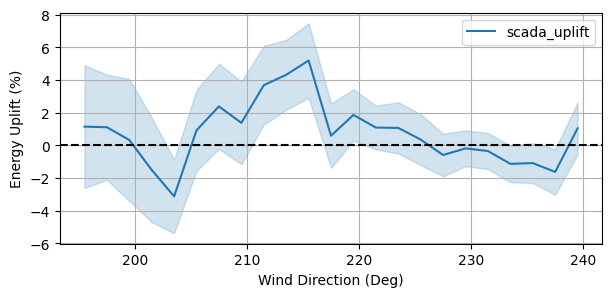

In [ ]:
t_wd = total_uplift_expected_power_by_wd(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4,5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=4.0,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)
t_wd.plot()

(1454, 56)
(1601, 56)
(2028, 56)
(2423, 56)
(3561, 56)
(3006, 56)
(2375, 56)
(2723, 56)
(2124, 56)
(830, 56)
(335, 56)


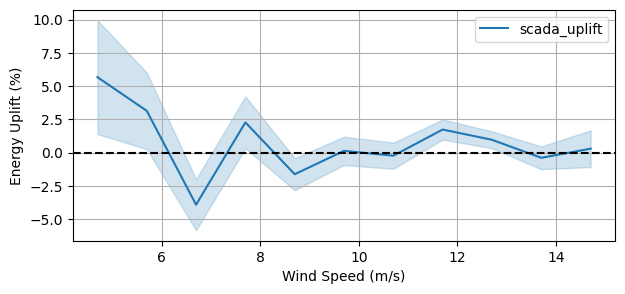

In [ ]:
t_wd = total_uplift_expected_power_by_ws(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4,5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=4.2,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)
t_wd.plot()

## Compute total uplift

In [ ]:
epao_standard_zero = total_uplift_expected_power(
    a_in=a_in,
    uplift_pairs=[("Baseline", "Controlled")],
    uplift_names=["scada_uplift"],
    test_turbines=[4, 5],
    use_predefined_wd=True,
    use_predefined_ws=True,
    wd_step=2.0,
    wd_min=0.5,
    ws_min=4.0,
    ws_step=1.0,
    use_standard_error=True,
    cov_terms="zero",
    remove_any_null_turbine_bins=False,
)

(23014, 54)


In [ ]:
epao_standard_zero.print_uplift()

0.56%, (0.19% - 0.94%)


In [ ]:
epao_standard_zero.uplift_results["scada_uplift"]

{'energy_uplift_ctr': 1.0056194957350637,
 'energy_uplift_var': 3.645369110912276e-06,
 'energy_uplift_lb': 1.0018773659503288,
 'energy_uplift_ub': 1.0093616255197986,
 'energy_uplift_ctr_pc': 0.5619495735063706,
 'energy_uplift_lb_pc': 0.18773659503288354,
 'energy_uplift_ub_pc': 0.9361625519798578,
 'df': shape: (234, 12)
 ┌────────┬────────┬─────────────┬────────────┬───┬──────────┬────────────┬────────────┬────────────┐
 │ wd_bin ┆ ws_bin ┆ weighted_fa ┆ weighted_f ┆ … ┆ weight   ┆ expected_p ┆ expected_p ┆ weighted_e │
 │ ---    ┆ ---    ┆ rm_power_Ba ┆ arm_power_ ┆   ┆ ---      ┆ ower_ratio ┆ ower_ratio ┆ xpected_po │
 │ f32    ┆ f32    ┆ seline      ┆ Controlled ┆   ┆ f64      ┆ ---        ┆ _var       ┆ wer_ratio_ │
 │        ┆        ┆ ---         ┆ ---        ┆   ┆          ┆ f32        ┆ ---        ┆ …          │
 │        ┆        ┆ f64         ┆ f64        ┆   ┆          ┆            ┆ f64        ┆ ---        │
 │        ┆        ┆             ┆            ┆   ┆          